<a href="https://colab.research.google.com/github/trendleader/ArtInt/blob/main/SUPERVISED_VS_UNSUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path

# Define working directory - use Path for cross-platform compatibility
#work_dir = Path(r'C:\Users\pjone\OneDrive\Desktop\NewPython')

# Change to working directory
#os.chdir(work_dir)

HEALTHCARE CLAIMS DATA: SUPERVISED vs UNSUPERVISED EXAMPLES
Generated 1348 claims records
Columns: ['member_id', 'claim_id', 'AGE', 'Sex', 'State', 'race', 'Type_of_Service', 'Provider_Type', 'Length_of_Stay', 'billed_amount', 'paid_amount', 'payment_status', 'denial_reason', 'Network_Status', 'readmit_indicator', 'Variance', 'Allowed_Amount', 'PCP_Specialty']

Dataset preview:
   member_id      claim_id  AGE Sex State              race Type_of_Service  \
0  100000000  202400000000   69   M    OH  African American      Outpatient   
1  100000001  202400000001   19   F    CA  African American    Professional   
2  100000002  202400000002   77   F    PA             Other      Outpatient   
3  100000003  202400000003   21   M    OH  African American       Emergency   
4  100000004  202400000004   53   F    FL          Hispanic    Professional   

  Provider_Type  Length_of_Stay  billed_amount  paid_amount payment_status  \
0     Physician             NaN           3872         2927       

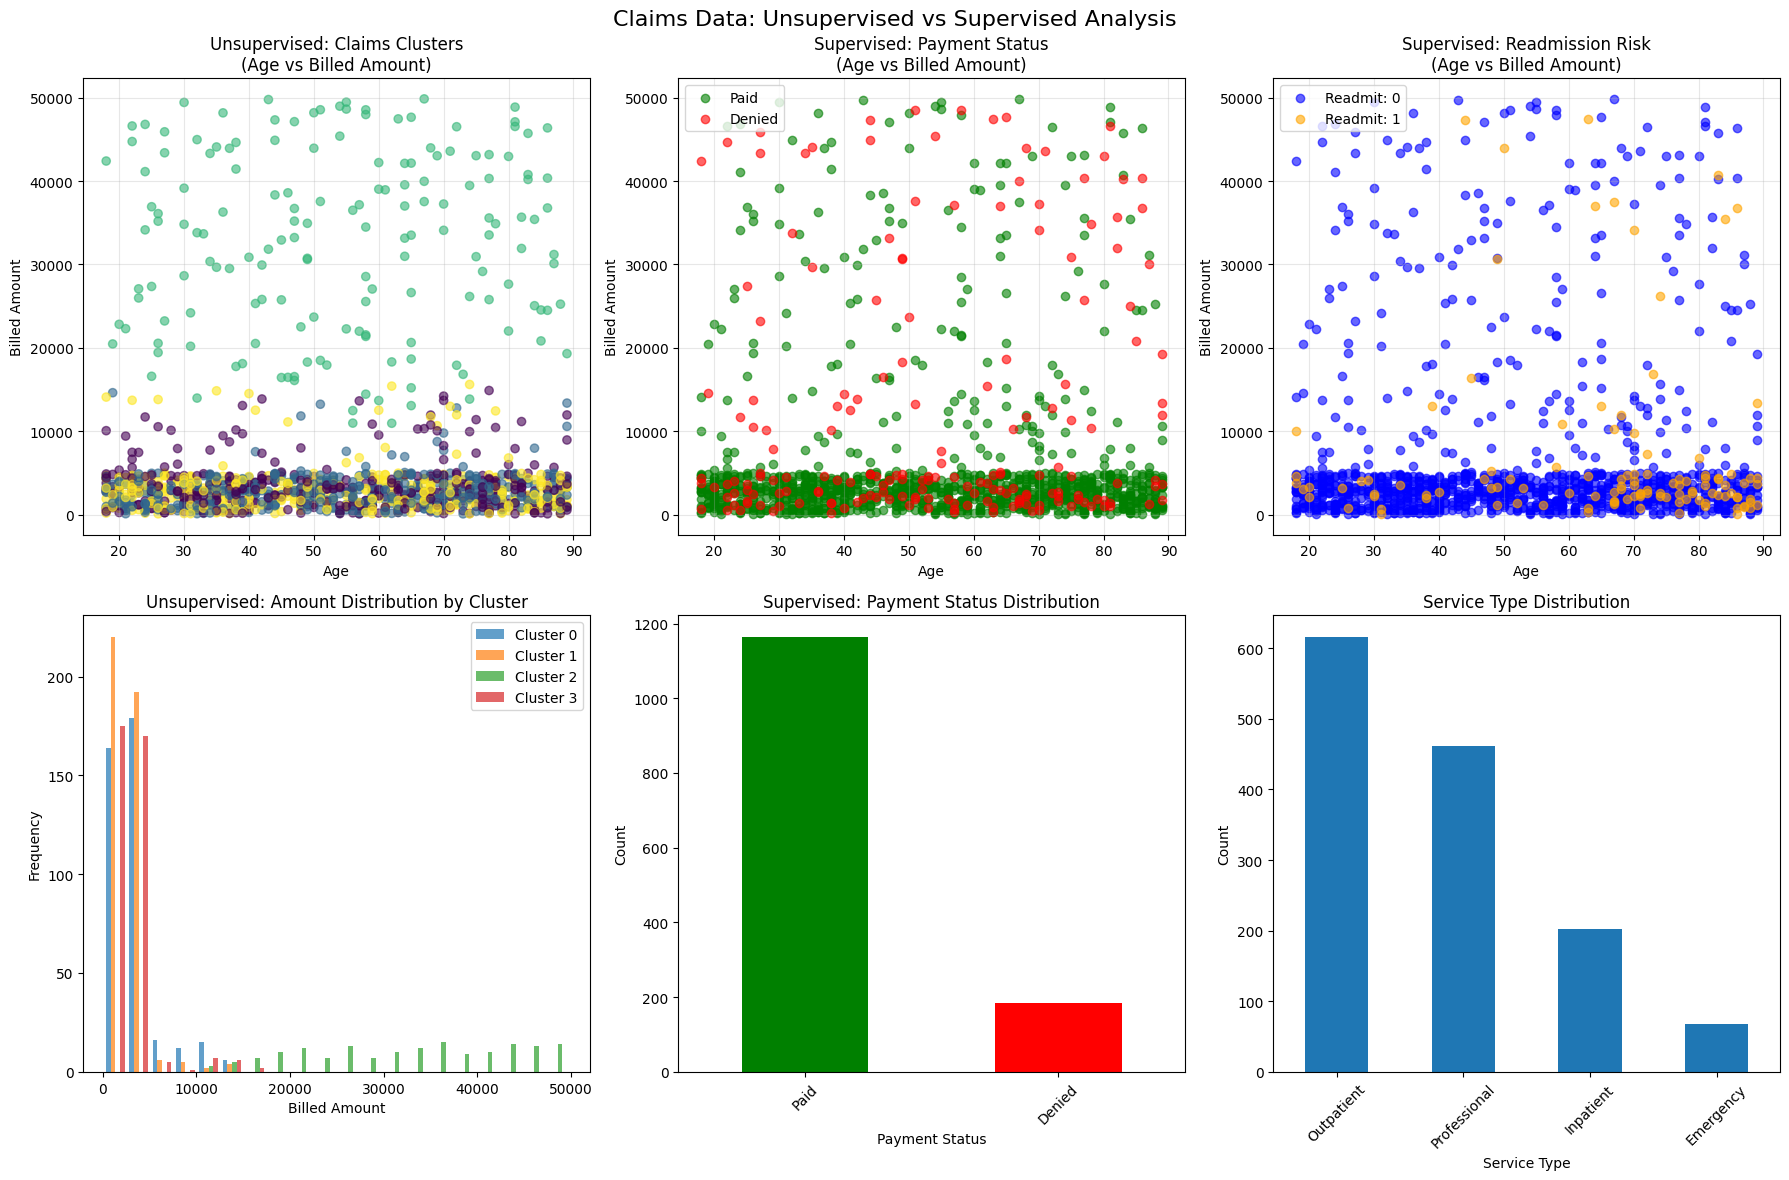


SUMMARY: WHEN IS CLAIMS DATA SUPERVISED vs UNSUPERVISED?
         Learning Type   Target Variable                        Goal                         Business Value
          Unsupervised              None Find natural claim patterns Member segmentation, anomaly detection
Supervised (Example 1)    payment_status       Predict claim denials    Fraud prevention, pre-authorization
Supervised (Example 2) readmit_indicator        Predict readmissions        Care management, cost reduction
Supervised (Example 3)   high_cost_claim    Predict high-cost claims               Risk assessment, pricing

KEY INSIGHT
Your claims dataset is CURRENTLY unsupervised because you're not
actively trying to predict a specific outcome. However, it contains
multiple built-in target variables that make it PERFECT for
supervised learning!

The same data can be both:
• UNSUPERVISED: 'What patterns exist in our claims?'
• SUPERVISED: 'Can we predict which claims will be denied?'

It depends on your analytical GOA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("HEALTHCARE CLAIMS DATA: SUPERVISED vs UNSUPERVISED EXAMPLES")
print("=" * 70)

# Since we can't access the actual file directly, let's create a realistic simulation
# based on the structure we observed
np.random.seed(42)

def generate_realistic_claims_data(n_claims=1348):
    """Generate realistic claims data matching the observed structure"""

    data = []

    # Realistic distributions based on the analysis
    states = ['CA', 'FL', 'TX', 'NY', 'NM', 'IL', 'PA', 'OH', 'MI', 'NC']
    races = ['Caucasian', 'Hispanic', 'African American', 'Asian', 'Other']
    service_types = ['Inpatient', 'Outpatient', 'Professional', 'Emergency']
    provider_types = ['Facility', 'Physician', 'Laboratory', 'Pharmacy']
    specialties = ['Family Medicine', 'Internal Medicine', 'Pediatrics', 'Emergency Medicine', 'Cardiology']

    for i in range(n_claims):
        age = np.random.randint(18, 90)
        sex = np.random.choice(['M', 'F'])

        # Service type affects other variables
        service_type = np.random.choice(service_types, p=[0.15, 0.45, 0.35, 0.05])

        # Length of stay (only for inpatient)
        if service_type == 'Inpatient':
            los = max(1, np.random.poisson(4))
        else:
            los = None

        # Billed amount varies by service type
        if service_type == 'Inpatient':
            billed_amount = np.random.randint(5000, 50000)
        elif service_type == 'Emergency':
            billed_amount = np.random.randint(1000, 15000)
        else:
            billed_amount = np.random.randint(100, 5000)

        # Payment status (some claims get denied)
        denial_prob = 0.1 + (billed_amount > 10000) * 0.3  # Higher amounts more likely denied
        payment_status = 'Denied' if np.random.random() < denial_prob else 'Paid'

        # Paid amount (0 if denied, otherwise some percentage of billed)
        if payment_status == 'Denied':
            paid_amount = 0
            denial_reason = np.random.choice([
                'Prior authorization required',
                'Medical necessity not established',
                'Non-participating provider',
                'Procedure/diagnosis code mismatch'
            ])
        else:
            paid_amount = int(billed_amount * np.random.uniform(0.6, 0.95))
            denial_reason = None

        # Network status affects payment
        network_status = np.random.choice(['In Network', 'Out of Network'], p=[0.7, 0.3])

        # Readmission indicator (more likely for older patients, longer stays)
        readmit_prob = 0.05 + (age > 65) * 0.1 + (los is not None and los > 5) * 0.15
        readmit_indicator = 1 if np.random.random() < readmit_prob else 0

        # Variance (difference between billed and allowed)
        allowed_amount = billed_amount * np.random.uniform(0.7, 1.0)
        variance = billed_amount - allowed_amount

        data.append({
            'member_id': 100000000 + i,
            'claim_id': 202400000000 + i,
            'AGE': age,
            'Sex': sex,
            'State': np.random.choice(states),
            'race': np.random.choice(races),
            'Type_of_Service': service_type,
            'Provider_Type': np.random.choice(provider_types),
            'Length_of_Stay': los,
            'billed_amount': billed_amount,
            'paid_amount': paid_amount,
            'payment_status': payment_status,
            'denial_reason': denial_reason,
            'Network_Status': network_status,
            'readmit_indicator': readmit_indicator,
            'Variance': int(variance),
            'Allowed_Amount': allowed_amount,
            'PCP_Specialty': np.random.choice(specialties)
        })

    return pd.DataFrame(data)

# Generate the dataset
df = generate_realistic_claims_data(1348)

print(f"Generated {len(df)} claims records")
print(f"Columns: {list(df.columns)}")
print("\nDataset preview:")
print(df.head())

print("\n" + "="*70)
print("SCENARIO 1: UNSUPERVISED LEARNING")
print("="*70)
print("GOAL: Discover natural patterns in claims without a specific target")
print()

# Unsupervised approach - cluster claims to find patterns
print("Approach: Cluster claims to identify member segments")

# Prepare features for clustering (exclude IDs and target-like variables)
unsupervised_features = [
    'AGE', 'billed_amount', 'paid_amount', 'Variance', 'Allowed_Amount'
]

# Add categorical variables as dummy variables
categorical_cols = ['Sex', 'Type_of_Service', 'Provider_Type', 'Network_Status']
df_encoded = pd.get_dummies(df[unsupervised_features + categorical_cols],
                           columns=categorical_cols, prefix=categorical_cols)

print(f"Features for clustering: {len(df_encoded.columns)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['claim_cluster'] = clusters

print(f"\nDiscovered {len(np.unique(clusters))} claim clusters:")
cluster_summary = df.groupby('claim_cluster').agg({
    'AGE': 'mean',
    'billed_amount': 'mean',
    'paid_amount': 'mean',
    'Type_of_Service': lambda x: x.mode()[0],
    'payment_status': lambda x: (x == 'Denied').mean()
}).round(2)

print(cluster_summary)

print("\nCluster Interpretation:")
for cluster_id in range(4):
    cluster_data = df[df['claim_cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_data)} claims):")
    print(f"  Avg Age: {cluster_data['AGE'].mean():.1f}")
    print(f"  Avg Billed: ${cluster_data['billed_amount'].mean():,.0f}")
    print(f"  Most Common Service: {cluster_data['Type_of_Service'].mode().iloc[0]}")
    print(f"  Denial Rate: {(cluster_data['payment_status'] == 'Denied').mean():.1%}")

print("\n" + "="*70)
print("SCENARIO 2: SUPERVISED LEARNING EXAMPLES")
print("="*70)

# Example 1: Predict claim denials
print("EXAMPLE 1: PREDICT CLAIM DENIALS")
print("Target: payment_status (Paid vs Denied)")
print()

# Prepare features for supervised learning
supervised_features = ['AGE', 'billed_amount', 'Variance', 'Allowed_Amount']
categorical_features = ['Sex', 'Type_of_Service', 'Provider_Type', 'Network_Status']

# Create feature matrix
X_supervised = pd.get_dummies(df[supervised_features + categorical_features],
                            columns=categorical_features)
y_denial = (df['payment_status'] == 'Denied').astype(int)

# Train model
X_train, X_test, y_train, y_test = train_test_split(X_supervised, y_denial,
                                                    test_size=0.3, random_state=42)

rf_denial = RandomForestClassifier(n_estimators=100, random_state=42)
rf_denial.fit(X_train, y_train)

y_pred_denial = rf_denial.predict(X_test)
print(f"Denial Prediction Accuracy: {accuracy_score(y_test, y_pred_denial):.3f}")

# Feature importance
denial_importance = pd.DataFrame({
    'feature': X_supervised.columns,
    'importance': rf_denial.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 5 denial prediction features:")
print(denial_importance.head())

print("\n" + "-"*40)
print("EXAMPLE 2: PREDICT READMISSIONS")
print("Target: readmit_indicator (0 vs 1)")
print()

# Only use inpatient claims for readmission prediction
inpatient_df = df[df['Type_of_Service'] == 'Inpatient'].copy()

if len(inpatient_df) > 50:  # Ensure we have enough data
    X_readmit = inpatient_df[['AGE', 'Length_of_Stay', 'billed_amount', 'paid_amount']]
    y_readmit = inpatient_df['readmit_indicator']

    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_readmit, y_readmit, test_size=0.3, random_state=42)

    rf_readmit = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_readmit.fit(X_train_r, y_train_r)

    y_pred_readmit = rf_readmit.predict(X_test_r)
    print(f"Readmission Prediction Accuracy: {accuracy_score(y_test_r, y_pred_readmit):.3f}")

    readmit_importance = pd.DataFrame({
        'feature': X_readmit.columns,
        'importance': rf_readmit.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Readmission prediction features:")
    print(readmit_importance)
else:
    print("Not enough inpatient data for readmission prediction")

print("\n" + "-"*40)
print("EXAMPLE 3: PREDICT HIGH-COST CLAIMS")
print("Target: High cost (>$10,000) vs Low cost")
print()

# Create high cost target
high_cost_threshold = 10000
y_high_cost = (df['billed_amount'] > high_cost_threshold).astype(int)

X_cost = pd.get_dummies(df[['AGE', 'Type_of_Service', 'Provider_Type', 'Network_Status']],
                       columns=['Type_of_Service', 'Provider_Type', 'Network_Status'])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cost, y_high_cost, test_size=0.3, random_state=42)

rf_cost = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cost.fit(X_train_c, y_train_c)

y_pred_cost = rf_cost.predict(X_test_c)
print(f"High-Cost Claim Prediction Accuracy: {accuracy_score(y_test_c, y_pred_cost):.3f}")

print(f"High-cost claims: {y_high_cost.sum()} out of {len(y_high_cost)} ({y_high_cost.mean():.1%})")

print("\n" + "="*70)
print("VISUAL COMPARISON")
print("="*70)

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Claims Data: Unsupervised vs Supervised Analysis', fontsize=16)

# Unsupervised: Clusters by age and amount
axes[0, 0].scatter(df['AGE'], df['billed_amount'], c=df['claim_cluster'],
                   cmap='viridis', alpha=0.6)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Billed Amount')
axes[0, 0].set_title('Unsupervised: Claims Clusters\n(Age vs Billed Amount)')
axes[0, 0].grid(True, alpha=0.3)

# Supervised: Payment status
payment_colors = {'Paid': 'green', 'Denied': 'red'}
for status in payment_colors:
    mask = df['payment_status'] == status
    axes[0, 1].scatter(df[mask]['AGE'], df[mask]['billed_amount'],
                      c=payment_colors[status], alpha=0.6, label=status)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Billed Amount')
axes[0, 1].set_title('Supervised: Payment Status\n(Age vs Billed Amount)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Supervised: Readmission indicator
readmit_colors = {0: 'blue', 1: 'orange'}
for readmit in readmit_colors:
    mask = df['readmit_indicator'] == readmit
    if mask.sum() > 0:
        axes[0, 2].scatter(df[mask]['AGE'], df[mask]['billed_amount'],
                          c=readmit_colors[readmit], alpha=0.6,
                          label=f'Readmit: {readmit}')
axes[0, 2].set_xlabel('Age')
axes[0, 2].set_ylabel('Billed Amount')
axes[0, 2].set_title('Supervised: Readmission Risk\n(Age vs Billed Amount)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Distribution plots
axes[1, 0].hist([df[df['claim_cluster'] == i]['billed_amount'] for i in range(4)],
               bins=20, alpha=0.7, label=[f'Cluster {i}' for i in range(4)])
axes[1, 0].set_xlabel('Billed Amount')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Unsupervised: Amount Distribution by Cluster')
axes[1, 0].legend()

# Payment status distribution
df['payment_status'].value_counts().plot(kind='bar', ax=axes[1, 1], color=['green', 'red'])
axes[1, 1].set_xlabel('Payment Status')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Supervised: Payment Status Distribution')
axes[1, 1].tick_params(axis='x', rotation=45)

# Service type distribution
df['Type_of_Service'].value_counts().plot(kind='bar', ax=axes[1, 2])
axes[1, 2].set_xlabel('Service Type')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Service Type Distribution')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("SUMMARY: WHEN IS CLAIMS DATA SUPERVISED vs UNSUPERVISED?")
print("="*70)

summary_data = {
    'Learning Type': ['Unsupervised', 'Supervised (Example 1)', 'Supervised (Example 2)', 'Supervised (Example 3)'],
    'Target Variable': ['None', 'payment_status', 'readmit_indicator', 'high_cost_claim'],
    'Goal': [
        'Find natural claim patterns',
        'Predict claim denials',
        'Predict readmissions',
        'Predict high-cost claims'
    ],
    'Business Value': [
        'Member segmentation, anomaly detection',
        'Fraud prevention, pre-authorization',
        'Care management, cost reduction',
        'Risk assessment, pricing'
    ]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n" + "="*70)
print("KEY INSIGHT")
print("="*70)
print("Your claims dataset is CURRENTLY unsupervised because you're not")
print("actively trying to predict a specific outcome. However, it contains")
print("multiple built-in target variables that make it PERFECT for")
print("supervised learning!")
print()
print("The same data can be both:")
print("• UNSUPERVISED: 'What patterns exist in our claims?'")
print("• SUPERVISED: 'Can we predict which claims will be denied?'")
print()
print("It depends on your analytical GOAL, not the data structure!")
